<a href="https://colab.research.google.com/github/MilianAlba/DMML2_CA/blob/main/DMML2_project_pepper_hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the same script as DMML2_project_pepper_hyperparameters.ipynb but to be run locally instead in colab

In [2]:
import pandas as pd
import os
import cv2
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow import keras
from keras import metrics

import matplotlib.colors as mcolors
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense


from keras.optimizers import Adam
from keras.preprocessing import image

import matplotlib.pyplot as plt
from keras import models
from keras import preprocessing
import keras_tuner as kt

print("Done importing packages!")

Done importing packages!


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (240, 240)

In [8]:
#data_dir = "../input/plantvillage-dataset/color"
data_dir = "plantville"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.28,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)
sample_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.08,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

print(train_dataset)


Found 23806 files belonging to 16 classes.
Using 17141 files for training.
Found 23806 files belonging to 16 classes.
Using 1904 files for validation.
Found 23806 files belonging to 16 classes.
Using 4761 files for validation.
<BatchDataset element_spec=(TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))>


In [9]:
class_names = sample_dataset.class_names
num_classes = len(class_names)
for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Apple___Apple_scab
2.  Apple___Black_rot
3.  Apple___Cedar_apple_rust
4.  Apple___healthy
5.  Pepper__bell___Bacterial_spot
6.  Pepper__bell___healthy
7.  Tomato___Bacterial_spot
8.  Tomato___Early_blight
9.  Tomato___Late_blight
10.  Tomato___Leaf_Mold
11.  Tomato___Septoria_leaf_spot
12.  Tomato___Spider_mites Two-spotted_spider_mite
13.  Tomato___Target_Spot
14.  Tomato___Tomato_Yellow_Leaf_Curl_Virus
15.  Tomato___Tomato_mosaic_virus
16.  Tomato___healthy


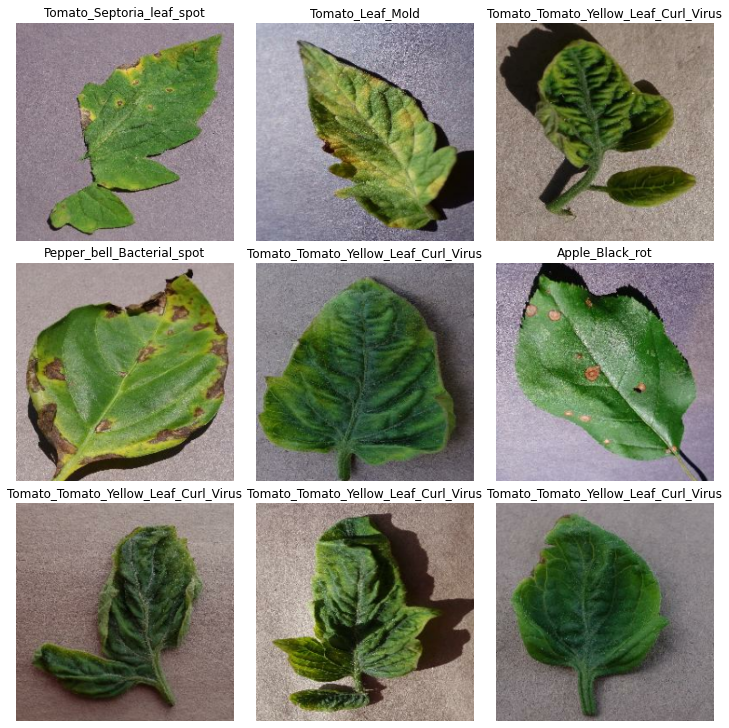

In [10]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

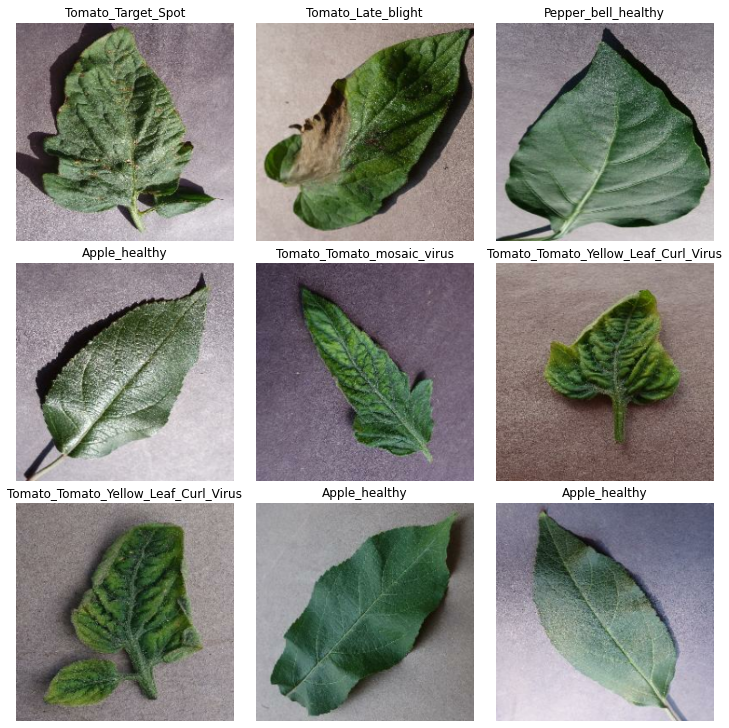

In [11]:
plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

In [12]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
#test_batches_outdoor = tf.data.experimental.cardinality(test_dataset_outdoor)

test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 120
Number of test batches: 29


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

sample_dataset = sample_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
def plot_metrics(history):
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [14]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [15]:
IMG_SHAPE = IMG_SIZE + (3,)

In [16]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [17]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
base_model = tf.keras.applications.InceptionResNetV2(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE,
                            )

In [18]:
image_batch, label_batch = next(iter(sample_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-08-01 09:45:08.307607: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 112140288 exceeds 10% of free system memory.
2022-08-01 09:45:08.437702: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 112140288 exceeds 10% of free system memory.
2022-08-01 09:45:08.466732: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 112140288 exceeds 10% of free system memory.
2022-08-01 09:45:08.544021: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 77070336 exceeds 10% of free system memory.
2022-08-01 09:45:08.754609: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 77070336 exceeds 10% of free system memory.


(32, 6, 6, 1536)


In [19]:
base_model.trainable = True

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1536)


In [21]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 16)


In [22]:
def model_builder(hp):
  inputs = tf.keras.Input(shape=(240, 240, 3))
  #x = data_augmentation(inputs)
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [22]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=2,
                     factor=3,
                     overwrite=True,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [23]:
#tuner.search(train_dataset, epochs=1, validation_data=validation_dataset, callbacks=[stop_early])
tuner.search(train_dataset, epochs=1, validation_data=validation_dataset)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 2 Complete [00h 22m 11s]
val_accuracy: 0.9799498915672302

Best val_accuracy So Far: 0.9799498915672302
Total elapsed time: 00h 44m 26s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.0001.



In [39]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=validation_dataset)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


62/62 [==============================] - 842s 13s/step - loss: 0.1614 - accuracy: 0.9283 - val_loss: 0.0337 - val_accuracy: 0.9900
Epoch 2/2
62/62 [==============================] - 824s 13s/step - loss: 0.0207 - accuracy: 0.9929 - val_loss: 0.0116 - val_accuracy: 0.9975
Best epoch: 2


In [40]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


62/62 [==============================] - 842s 13s/step - loss: 0.0356 - accuracy: 0.9889 - val_loss: 0.0186 - val_accuracy: 0.9950
Epoch 2/2
62/62 [==============================] - 824s 13s/step - loss: 0.0079 - accuracy: 0.9980 - val_loss: 0.0054 - val_accuracy: 0.9975


In [41]:
eval_result = hypermodel.evaluate(test_dataset)

print("[test loss, test accuracy]:", eval_result)

3/3 [==============================] - 28s 9s/step - loss: 0.0017 - accuracy: 1.0000
[test loss, test accuracy]: [0.0016784841427579522, 1.0]


In [42]:
eval_result = hypermodel.evaluate(test_dataset_outdoor)

print("[test loss, test accuracy]:", eval_result)

1/1 [==============================] - 7s 7s/step - loss: 0.6406 - accuracy: 0.8824
[test loss, test accuracy]: [0.6405597925186157, 0.8823529481887817]


In [43]:
eval_result = hypermodel.evaluate(validation_dataset)

print("[val loss, val accuracy]:", eval_result)

13/13 [==============================] - 121s 9s/step - loss: 0.0055 - accuracy: 0.9975
[val loss, val accuracy]: [0.005479393061250448, 0.9974937438964844]


In [ ]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [ ]:
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

NameError: ignored

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 1

In [ ]:
len(train_dataset)

62

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


62/62 [==============================] - 623s 10s/step - loss: 0.5892 - accuracy: 0.6949 - val_loss: 0.2917 - val_accuracy: 0.9198


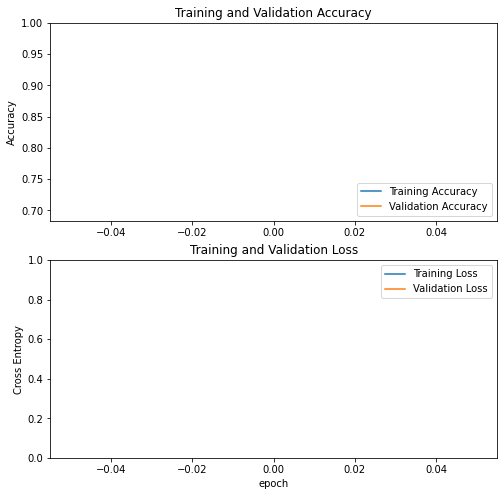

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

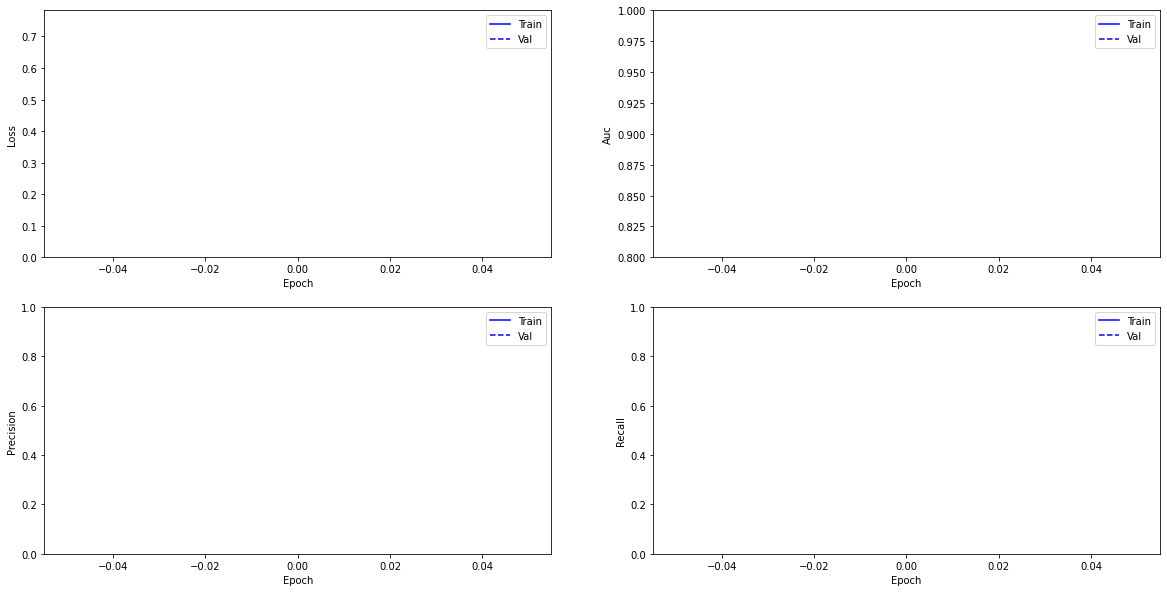

In [ ]:
plot_metrics(history)

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 700

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [ ]:
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 240, 240, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 240, 240, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                      

In [ ]:
len(model.trainable_variables)

52

In [ ]:
#fine_tune_epochs = 15
fine_tune_epochs = 1
total_epochs =  initial_epochs + fine_tune_epochs
total_epochs = 1

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


62/62 [==============================] - 727s 12s/step - loss: 0.1846 - accuracy: 0.9313 - val_loss: 0.0591 - val_accuracy: 0.9825


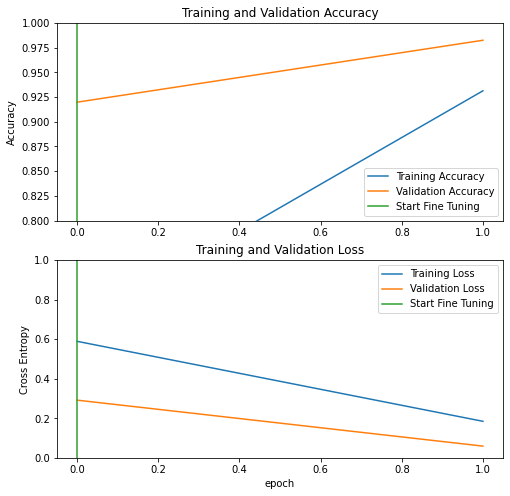

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

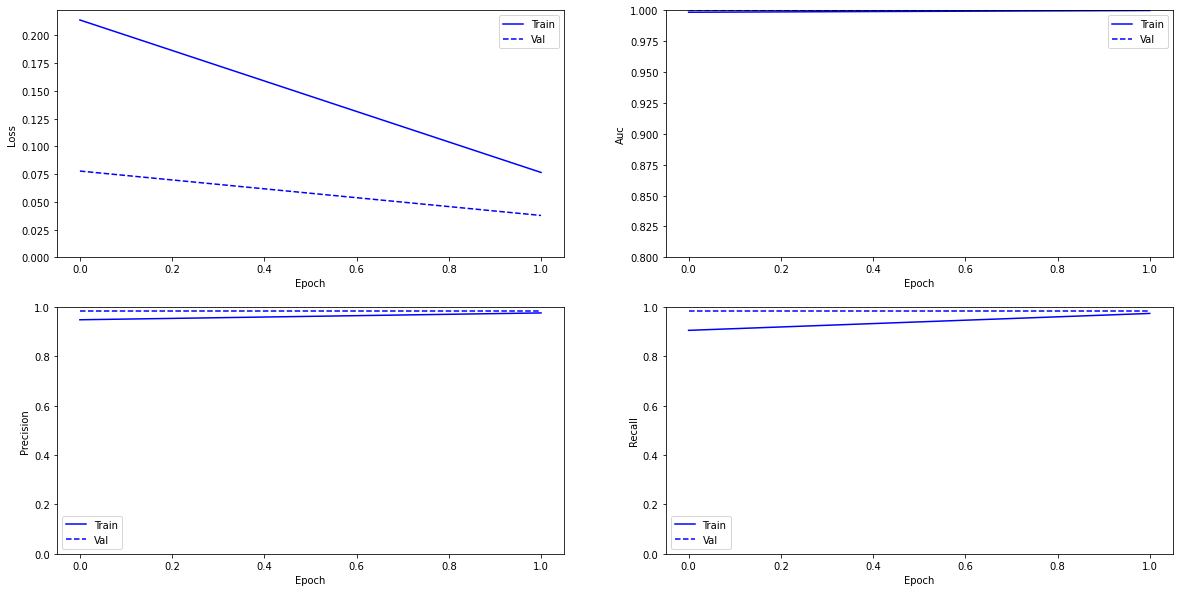

In [ ]:
plot_metrics(history_fine)

In [ ]:
result = model.evaluate(test_dataset)

3/3 [==============================] - 25s 8s/step - loss: 0.0594 - accuracy: 0.9896


In [ ]:
result = model.evaluate(test_dataset_outdoor)

1/1 [==============================] - 7s 7s/step - loss: 0.2310 - accuracy: 0.9412


In [ ]:
result = model.evaluate(validation_dataset)

13/13 [==============================] - 101s 8s/step - loss: 0.0576 - accuracy: 0.9850


In [ ]:
print(len(test_dataset))

3


In [ ]:
print(len(validation_dataset))

13


In [ ]:
print(len(train_dataset))

62


In [ ]:
metrics = ["loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall", "auc"]
for i in range(len(result)):
    print("{} : {}".format(metrics[i],round(result[i], 3)))

loss : 0.035
tp : 288.0
fp : 5.0
tn : 3511.0
fn : 5.0
accuracy : 0.983
precision : 0.983
recall : 0.983
auc : 1.0


Predictions:
 [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Labels:
 [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]


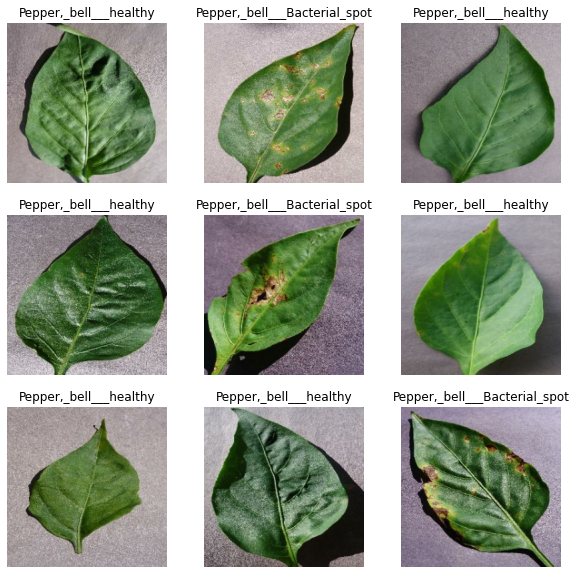

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
models.save_model(model, "./inception_v3")

INFO:tensorflow:Assets written to: ./inception_v3/assets


INFO:tensorflow:Assets written to: ./inception_v3/assets
